In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer
from datasets import Dataset
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from datasets import concatenate_datasets
import torch
import torch.nn as nn
import numpy as np
import re
from sklearn.metrics import f1_score
from torch.optim import AdamW
from tqdm import tqdm

pd.options.display.max_colwidth = 100

In [2]:
from IPython.core.magic import register_cell_magic
from IPython import get_ipython


@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

In [3]:
df = pd.read_parquet('./data/train.parquet')

# Exploration data analysis

In [4]:
df.dtypes

id               object
content          object
lang             object
manipulative       bool
techniques       object
trigger_words    object
dtype: object

In [5]:
# Display basic dataset information
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns.tolist())
df.head()

Dataset Shape: (3822, 6)
Dataset Columns: ['id', 'content', 'lang', 'manipulative', 'techniques', 'trigger_words']


,id,content,lang,manipulative,techniques,trigger_words
0,0bb0c7fa-101b-4583-a5f9-9d503339141c,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",uk,True,"[euphoria, loaded_language]","[[27, 63], [65, 88], [90, 183], [186, 308]]"
1,7159f802-6f99-4e9d-97bd-6f565a4a0fae,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...",ru,True,"[loaded_language, cherry_picking]","[[0, 40], [123, 137], [180, 251], [253, 274]]"
2,e6a427f1-211f-405f-bd8b-70798458d656,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,uk,True,"[loaded_language, euphoria]","[[55, 100]]"
3,1647a352-4cd3-40f6-bfa1-d87d42e34eea,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,uk,False,None,None
4,9c01de00-841f-4b50-9407-104e9ffb03bf,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...",ru,True,[loaded_language],"[[114, 144]]"


In [6]:
def extract_unique_techniques(df):
    # Check if 'techniques' column exists
    if 'techniques' not in df.columns:
        raise ValueError("DataFrame must contain a 'techniques' column")

    # Initialize an empty set to store unique techniques
    unique_techniques = set()

    # Iterate through each row
    for techniques_array in df['techniques']:
        # Skip None or NaN values
        if techniques_array is None or (isinstance(techniques_array, float) and np.isnan(techniques_array)):
            continue

        # Add each technique to the set
        for technique in techniques_array:
            unique_techniques.add(technique)

    # Convert set to sorted list
    return sorted(list(unique_techniques))

In [7]:
technique_list = extract_unique_techniques(df)
technique_list

['appeal_to_fear',
 'bandwagon',
 'cherry_picking',
 'cliche',
 'euphoria',
 'fud',
 'glittering_generalities',
 'loaded_language',
 'straw_man',
 'whataboutism']

In [8]:
df_exploded = df.explode('techniques')
df_exploded['techniques'].value_counts()

techniques
loaded_language            1973
cherry_picking              512
glittering_generalities     483
cliche                      463
euphoria                    462
fud                         385
appeal_to_fear              300
whataboutism                158
bandwagon                   157
straw_man                   138
Name: count, dtype: int64

In [9]:
# Display detailed information about the dataset
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3822 entries, 0 to 3821
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3822 non-null   object
 1   content        3822 non-null   object
 2   lang           3822 non-null   object
 3   manipulative   3822 non-null   bool  
 4   techniques     2589 non-null   object
 5   trigger_words  2589 non-null   object
dtypes: bool(1), object(5)
memory usage: 153.2+ KB

Missing Values:
id                  0
content             0
lang                0
manipulative        0
techniques       1233
trigger_words    1233
dtype: int64


<Figure size 600x400 with 0 Axes>

<Axes: xlabel='lang'>

Text(0.5, 1.0, 'Distribution of Languages')

Text(0.5, 0, 'Language')

Text(0, 0.5, 'Count')

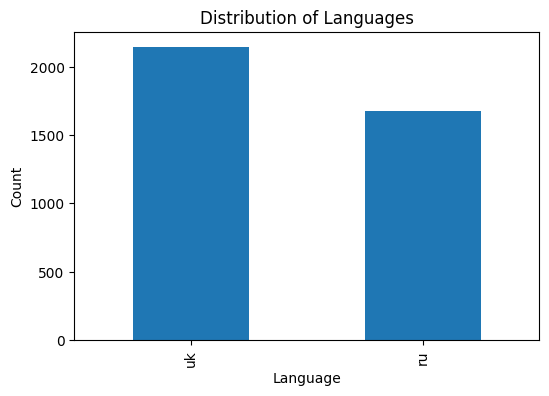

<Figure size 600x400 with 0 Axes>

<Axes: xlabel='manipulative'>

Text(0.5, 1.0, 'Distribution of Manipulative Flag')

Text(0.5, 0, 'Manipulative')

Text(0, 0.5, 'Count')

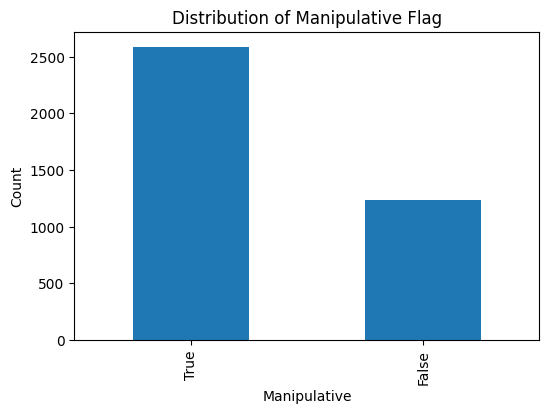

In [10]:
# Plot the distribution of languages in the dataset
plt.figure(figsize=(6,4))
df['lang'].value_counts().plot(kind='bar')
plt.title('Distribution of Languages')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

# Plot the distribution of the manipulative flag
plt.figure(figsize=(6,4))
df['manipulative'].value_counts().plot(kind='bar')
plt.title('Distribution of Manipulative Flag')
plt.xlabel('Manipulative')
plt.ylabel('Count')
plt.show()


## Try to understand more about text

### Text cleaning

In [11]:
# Define a function for basic text cleaning
def clean_text(text):
    # Remove newline characters and extra spaces
    text = (
        text
        .replace('\n', ' ')
        .replace("&nbsp;", " ")
        .replace(u'\u00A0', " ")
        .replace("  ", " ")
        .strip()
    )
    text = re.sub(r'\s+', ' ', text)
    # You can add additional cleaning steps (e.g., removing URLs, punctuation) as needed
    return text

# Apply cleaning to the 'content' column and create a new column 'clean_content'
df['clean_content'] = df['content'].apply(clean_text)

# Show an example of cleaned content
print("Example of Cleaned Content (Row 0):")
df[['content','clean_content']]

Example of Cleaned Content (Row 0):


,content,clean_content
0,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...","Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа..."
1,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...","Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про..."
2,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,🤩 Тим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні пр...
3,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...
4,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...","Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко..."
...,...,...
3817,"🤭\nросія ставить ППО на дахах адмінбудівель\nросійське керівництво перелякане, що військова пром...","🤭 росія ставить ППО на дахах адмінбудівель російське керівництво перелякане, що військова промис..."
3818,"К слову, Бабий не просто «ларечник», а и человек народного депутата СН Дубнова, а Дубнов - родст...","К слову, Бабий не просто «ларечник», а и человек народного депутата СН Дубнова, а Дубнов - родст..."
3819,"Глава ФСБ Бортников ответил журналистам, почему те, кто совершает преступления против России и р...","Глава ФСБ Бортников ответил журналистам, почему те, кто совершает преступления против России и р..."
3820,В ДНР завозили наркотики в бытовой технике\nОб этом сообщили в пресс-службе МВД по ДНР.\nУ предп...,В ДНР завозили наркотики в бытовой технике Об этом сообщили в пресс-службе МВД по ДНР. У предпри...


### Text **length** distribution

In [12]:
df['content'].str.len().describe()

count    3822.000000
mean      607.712716
std       606.421275
min       101.000000
25%       229.250000
50%       415.000000
75%       762.000000
max      4124.000000
Name: content, dtype: float64

<Axes: >

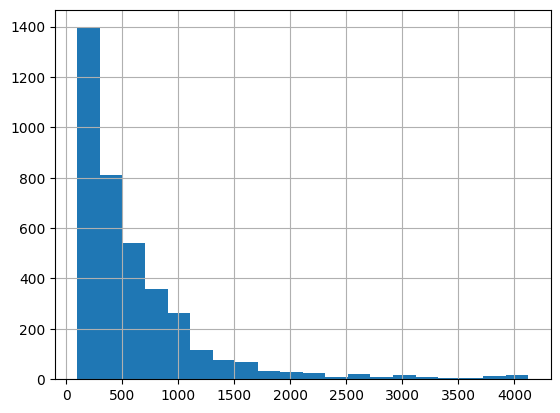

In [13]:
df['content'].str.len().hist(bins=20)

### Words count

In [14]:
df['words_count'] = df['content'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
print("\nDataFrame with words count:")
df[['content', 'words_count']].head()


DataFrame with words count:


,content,words_count
0,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",49
1,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...",160
2,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,36
3,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,124
4,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...",24


In [15]:
df['words_count'].describe()

count    3822.000000
mean       86.093145
std        85.902422
min         9.000000
25%        33.000000
50%        60.000000
75%       106.000000
max       707.000000
Name: words_count, dtype: float64

## Trigger words extraction

In [16]:
def extract_trigger_words(row):
    text = row['content']
    tw = row['trigger_words']
    # Check if trigger_words is not a numpy array or list (e.g. it's NaN)
    if not isinstance(tw, (np.ndarray, list)):
        return None
    # If the array/list is empty, return None.
    if len(tw) == 0:
        return None
    extracted_words = []
    # Iterate over each subarray representing [start, end] indexes.
    for indices in tw:
        # Ensure that indices is array-like with exactly two elements.
        if not isinstance(indices, (np.ndarray, list)) or len(indices) != 2:
            continue
        start, end = indices[0], indices[1]
        extracted_words.append(text[start:end])
    return extracted_words

# Apply the extraction function row-wise to create a new column with the trigger words.
df['trigger_words_text'] = df.apply(extract_trigger_words, axis=1)

print("DataFrame with Trigger Words Extracted:")
df[['clean_content', 'techniques','trigger_words', 'trigger_words_text']]

DataFrame with Trigger Words Extracted:


,clean_content,techniques,trigger_words,trigger_words_text
0,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...","[euphoria, loaded_language]","[[27, 63], [65, 88], [90, 183], [186, 308]]","[від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду..."
1,"Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про...","[loaded_language, cherry_picking]","[[0, 40], [123, 137], [180, 251], [253, 274]]","[Недавно 95 квартал жёстко поглумился над, дегенеративные, Как обычно стать на колени и лизать у..."
2,🤩 Тим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні пр...,"[loaded_language, euphoria]","[[55, 100]]",[він оточений з невідомих простій русні причин]
3,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,None,None,None
4,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригады 1-го АК 8-й армии ЮВО ВС России точным огнем, ко...",[loaded_language],"[[114, 144]]",[уничтожают украинских нацистов]
...,...,...,...,...
3817,"🤭 росія ставить ППО на дахах адмінбудівель російське керівництво перелякане, що військова промис...","[loaded_language, euphoria]","[[2, 7], [43, 75], [77, 143], [145, 178], [340, 385], [492, 526], [540, 571]]","[росія, російське керівництво перелякане, що військова промисловість нашої держави може виготови..."
3818,"К слову, Бабий не просто «ларечник», а и человек народного депутата СН Дубнова, а Дубнов - родст...",[loaded_language],"[[25, 35], [103, 128], [149, 166]]","[«ларечник», проворовавшегося министра, Такой вот подряд.]"
3819,"Глава ФСБ Бортников ответил журналистам, почему те, кто совершает преступления против России и р...",None,None,None
3820,В ДНР завозили наркотики в бытовой технике Об этом сообщили в пресс-службе МВД по ДНР. У предпри...,None,None,None


## Most used words per technique

In [17]:
from collections import defaultdict, Counter
import itertools
import stopwordsiso as stopwords

def remove_ukrainian_stopwords(tokens: list) -> list:
    """
    Remove Ukrainian stopwords from a list of tokens using the stopwords-iso dictionary.

    Parameters:
        tokens (list): A list of word tokens (strings).

    Returns:
        list: The list of tokens with Ukrainian stopwords removed.
    """
    # Retrieve Ukrainian stopwords from stopwords-iso.
    uk_stopwords = stopwords.stopwords("uk")
    ru_stopwords = stopwords.stopwords("ru")
    custom_stopwords = {'в', 'на', 'і', 'не', 'у', 'за', '-','—', '–', 'c', 'что', 'всі', 'хто', '"', "'", ",", "вже", 'які', 'ще'}
    uk_ru_stopwords = uk_stopwords.union(custom_stopwords).union(ru_stopwords)
    # Filter tokens, ensuring case-insensitive comparison.
    filtered_tokens = [token for token in tokens if token.lower() not in uk_ru_stopwords]
    return filtered_tokens

# Create a dictionary to collect trigger words for each technique.
technique_trigger_words = defaultdict(list)

# Iterate over each row in the DataFrame.
# We assume that df has a "techniques" column (list of techniques per row)
# and a "trigger_words_text" column (list of extracted trigger words).
for _, row in df.iterrows():
    techniques_in_row = row.get("techniques")
    trigger_words_text = row.get("trigger_words_text")
    if not isinstance(techniques_in_row, np.ndarray) or not isinstance(trigger_words_text, list):
        continue

    trigger_words = remove_ukrainian_stopwords(list(itertools.chain.from_iterable([t.split() for t in trigger_words_text])))
    for tech in techniques_in_row:
        technique_trigger_words[tech].extend(trigger_words)

# Now, for each technique, count frequency and print the top 5 triggering words.
top_n = 10
print("Top triggering words per technique:")
for technique, words in technique_trigger_words.items():
    counter = Counter(words)
    top_words = counter.most_common(top_n)
    print(f"\nTechnique: {technique}")
    for word, count in top_words:
        print(f"  {word}: {count}")


Top triggering words per technique:

Technique: euphoria
  ВСУ: 33
  окупантів: 25
  України: 22
  Слава: 22
  наших: 21
  России: 20
  росіян: 19
  ЗСУ: 19
  нашу: 18
  наші: 17

Technique: loaded_language
  ВСУ: 67
  Украине: 65
  Украины: 63
  людей: 61
  України: 59
  щоб: 56
  России: 53
  США: 52
  буде: 52
  дуже: 52

Technique: cherry_picking
  Украины: 48
  ВСУ: 44
  России: 42
  Украине: 40
  Украина: 29
  Зеленского: 27
  США: 26
  людей: 24
  РФ: 23
  том,: 22

Technique: glittering_generalities
  України: 54
  наших: 52
  нашу: 50
  Україна: 48
  Разом: 47
  Слава: 45
  наші: 42
  щоб: 38
  буде: 35
  лише: 33

Technique: cliche
  Слава: 34
  України: 27
  наших: 27
  людей: 24
  війни: 22
  России: 22
  Разом: 22
  Україна: 20
  дуже: 20
  щоб: 20

Technique: appeal_to_fear
  Украине: 26
  Украины: 25
  людей: 22
  Украина: 20
  США: 19
  ВСУ: 19
  России: 16
  украинских: 15
  Зеленского: 14
  ТЦК: 13

Technique: bandwagon
  😄: 14
  війни: 13
  разом: 10
  його: 9
  люде

<Figure size 1000x600 with 0 Axes>

(array([ 3.,  7.,  3.,  9., 17., 24., 30., 60., 53., 58., 77., 46., 43.,
        57., 46., 40., 43., 46., 51., 37., 36., 48., 48., 42., 53., 43.,
        50., 44., 36., 41., 32., 49., 49., 45., 41., 33., 38., 39., 38.,
        34., 32., 40., 33., 21., 27., 36., 26., 26., 24., 28., 22., 45.,
        25., 24., 28., 23., 29., 26., 28., 20., 27., 20., 19., 20., 19.,
        17., 25., 18., 17., 16., 29., 18., 19., 25., 18., 20., 21., 19.,
        28., 19., 22., 17., 21., 20., 16., 17., 21., 13., 15., 18., 24.,
        15., 18.,  9., 11., 17., 19.,  8., 10., 16., 12., 12., 14., 11.,
        11., 12.,  8., 13., 16., 14.,  6.,  9.,  9., 10.,  8.,  9., 14.,
        15., 10., 10., 10., 15.,  9.,  7., 10., 11., 10.,  7.,  8.,  9.,
         7., 15.,  9., 11., 15.,  6., 11.,  4.,  8.,  6., 10., 10.,  4.,
        12.,  9.,  2.,  4.,  5.,  5.,  3.,  6.,  8.,  6.,  7.,  5.,  9.,
         7.,  3.,  4.,  4.,  0.,  4., 11.,  8.,  3.,  2.,  6.,  2.,  1.,
         3.,  2.,  7.,  4.,  1.,  3.,  8.,  4.,  3.

Text(0.5, 1.0, 'Distribution of words count')

Text(0.5, 0, 'Word Count')

Text(0, 0.5, 'Frequency')

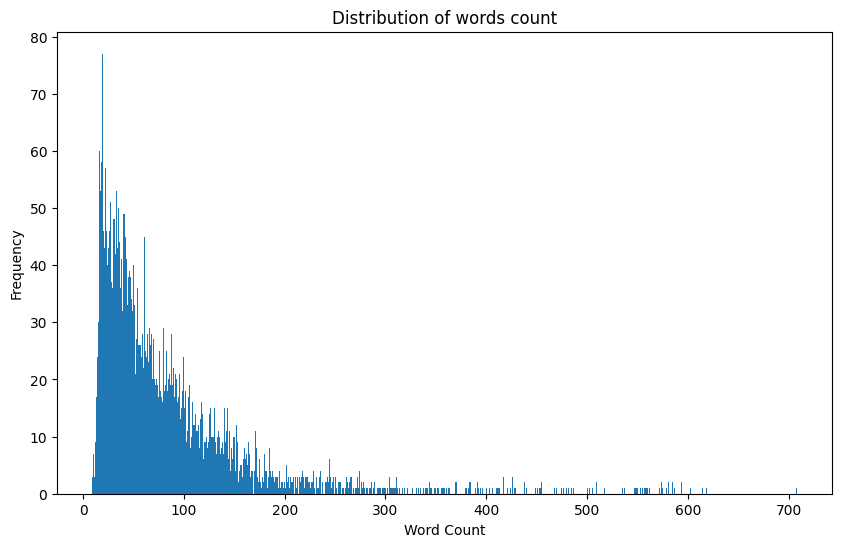

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(df['words_count'], bins=range(min(df['words_count']), max(df['words_count']) + 2))
plt.title("Distribution of words count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Calculate word frequency

In [19]:
import re
from collections import Counter

# Concatenate all text entries into a single string
all_text = " ".join(df['content'].dropna())

# Convert to lowercase and remove punctuation (basic cleaning)
all_text = all_text.lower()
all_text = re.sub(r'[^\w\s]', '', all_text)

# Split the text into words and count frequency
words = all_text.split()
word_counts = Counter(words)

# Convert the word counts to a DataFrame for easier visualization
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

print("\nTop words by frequency:")
word_counts_df.head(10)


Top words by frequency:


,word,count
137,в,7547
72,на,6272
63,и,3832
116,не,3520
16,та,3278
96,у,2996
42,з,2560
32,і,2472
107,за,2068
228,до,1899


In [20]:
word_counts_df.sort_values(by='count', ascending=True).head(10)

,word,count
47680,набираем,1
53607,зенітноракетним,1
64508,новация,1
53608,комплексам,1
65424,десантом,1
64510,разработают,1
53610,співпрацюватимуть,1
64511,аудио,1
53611,туристично,1
65423,экипажем,1


## Use tokenizer to analyze token count

In [21]:
model_name = 'youscan/ukr-roberta-base'
max_tokens_length=512

Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors


<Figure size 1000x600 with 0 Axes>

(array([2., 2., 3., ..., 0., 0., 1.]),
 array([  18.,   19.,   20., ..., 1465., 1466., 1467.]),
 <BarContainer object of 1449 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

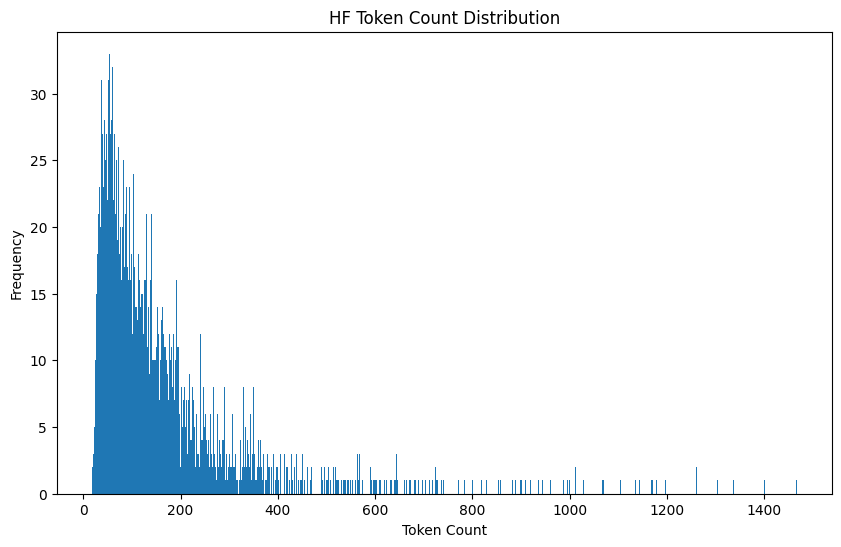

In [22]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
df['hf_token_count'] = df['clean_content'].apply(lambda x: len(tokenizer.tokenize(x)))

plt.figure(figsize=(10, 6))
plt.hist(df['hf_token_count'], bins=range(min(df['hf_token_count']), max(df['hf_token_count'])+2))
plt.title("HF Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

<Figure size 1000x600 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  25.,   26.,   27., ..., 1336., 1337., 1338.]),
 <BarContainer object of 1313 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: appeal_to_fear')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

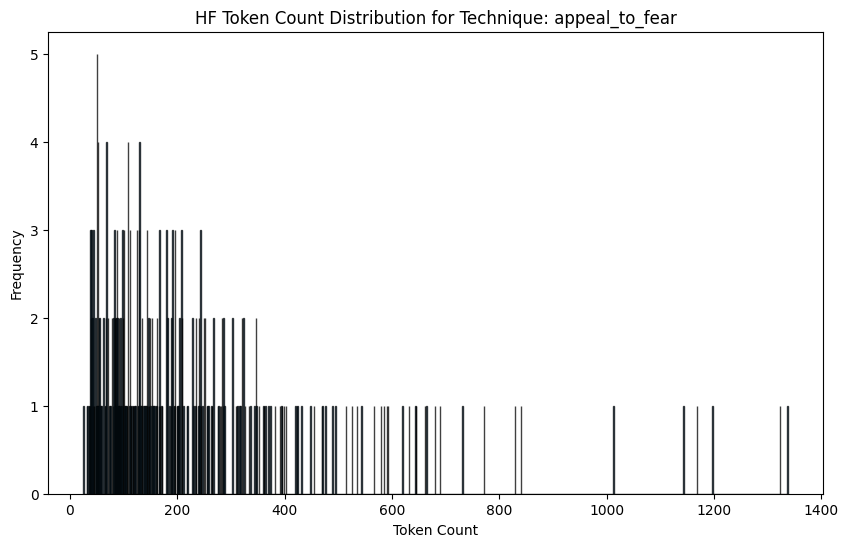

<Figure size 1000x600 with 0 Axes>

(array([1., 1., 1., ..., 0., 0., 1.]),
 array([  29.,   30.,   31., ..., 1399., 1400., 1401.]),
 <BarContainer object of 1372 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: bandwagon')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

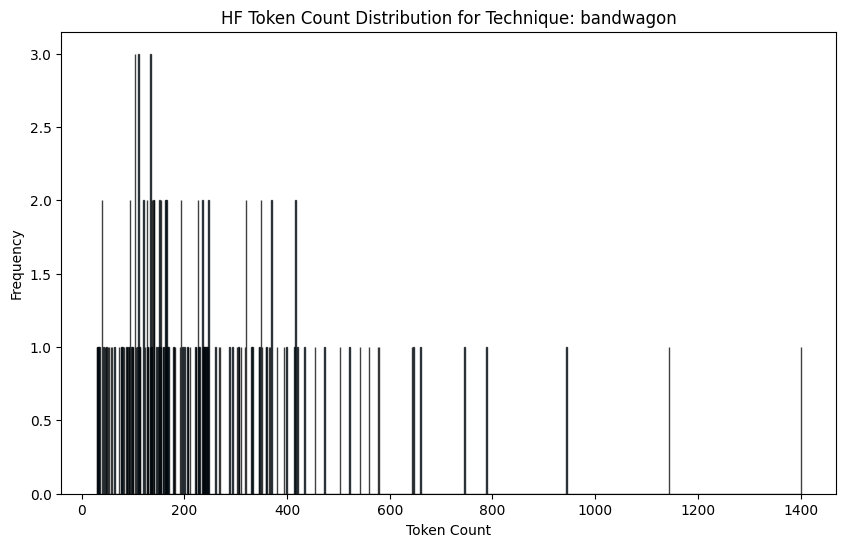

<Figure size 1000x600 with 0 Axes>

(array([1., 2., 0., ..., 0., 0., 1.]),
 array([  32.,   33.,   34., ..., 1465., 1466., 1467.]),
 <BarContainer object of 1435 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: cherry_picking')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

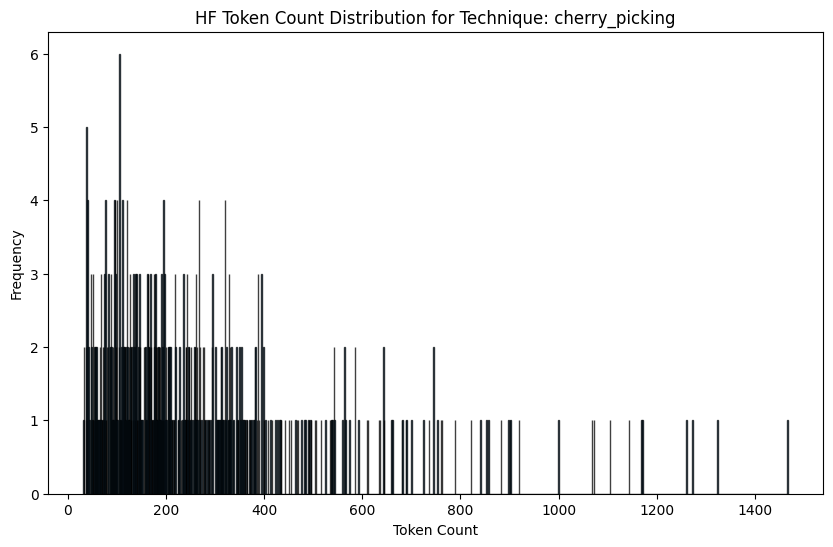

<Figure size 1000x600 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  24.,   25.,   26., ..., 1322., 1323., 1324.]),
 <BarContainer object of 1300 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: cliche')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

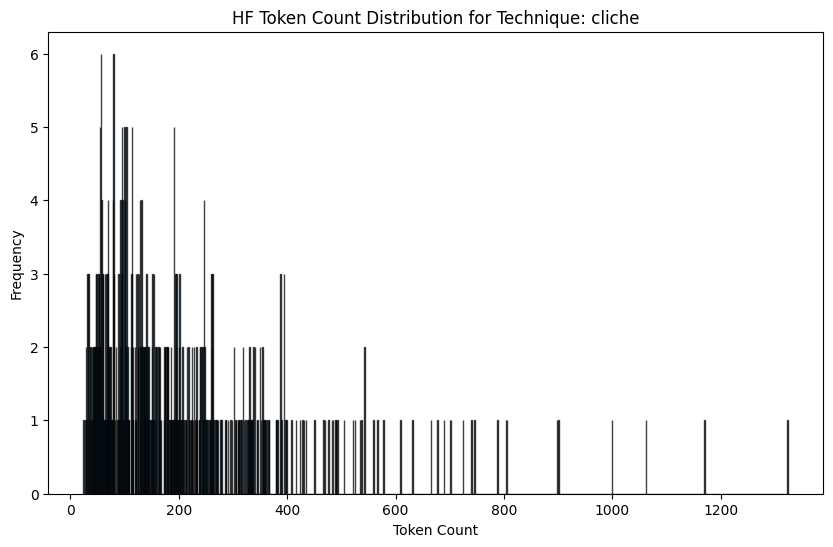

<Figure size 1000x600 with 0 Axes>

(array([1., 0., 1., ..., 0., 0., 1.]),
 array([  22.,   23.,   24., ..., 1114., 1115., 1116.]),
 <BarContainer object of 1094 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: euphoria')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

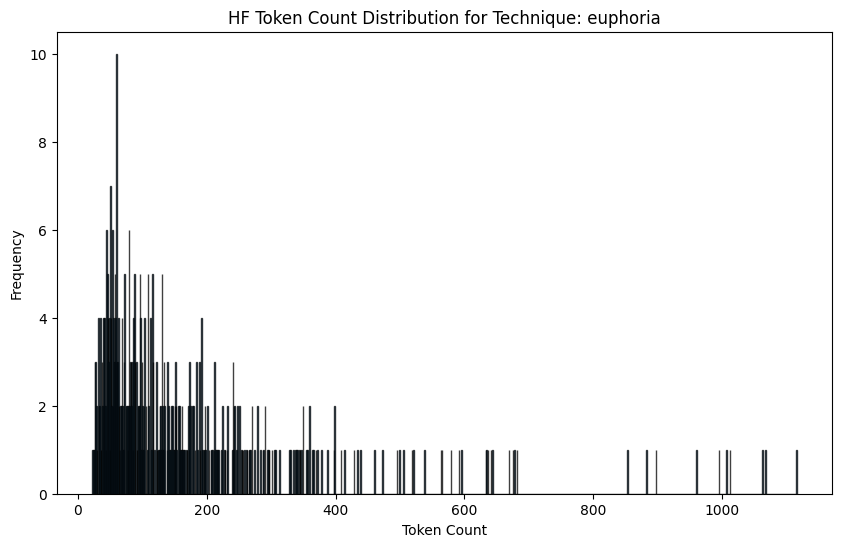

<Figure size 1000x600 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  24.,   25.,   26., ..., 1336., 1337., 1338.]),
 <BarContainer object of 1314 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: fud')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

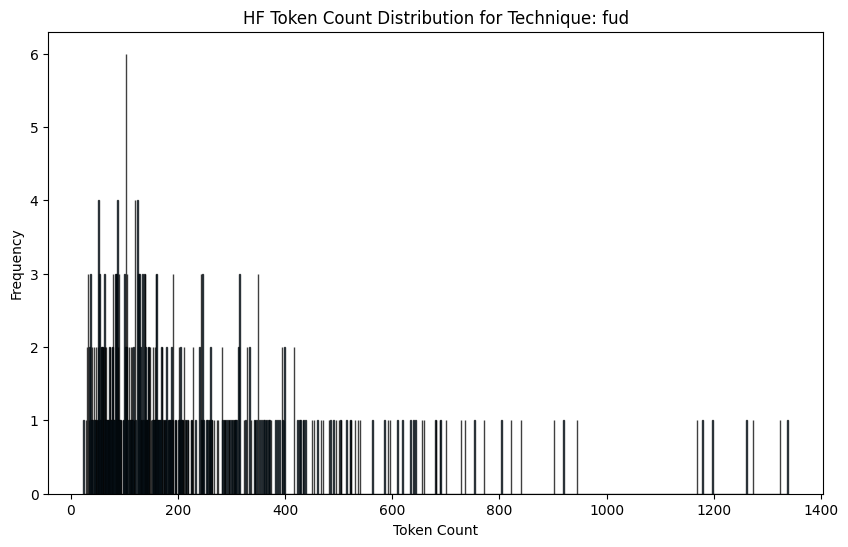

<Figure size 1000x600 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  22.,   23.,   24., ..., 1399., 1400., 1401.]),
 <BarContainer object of 1379 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: glittering_generalities')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

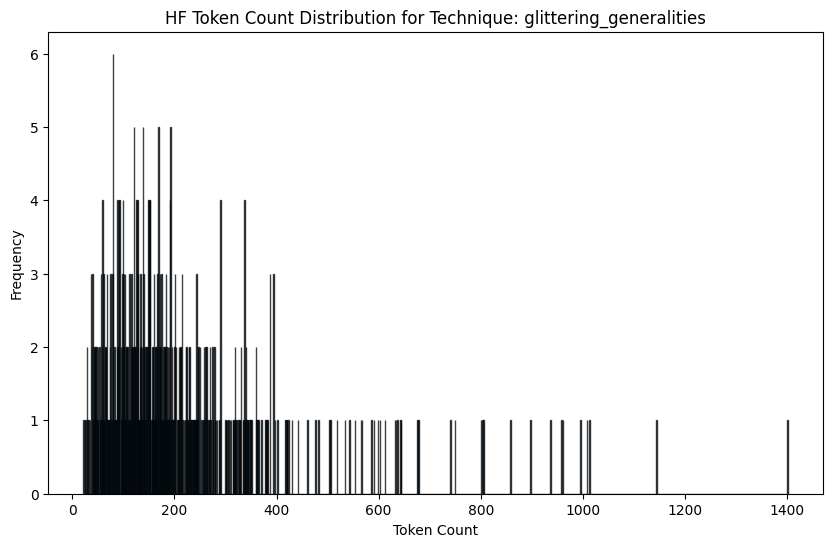

<Figure size 1000x600 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  18.,   19.,   20., ..., 1465., 1466., 1467.]),
 <BarContainer object of 1449 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: loaded_language')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

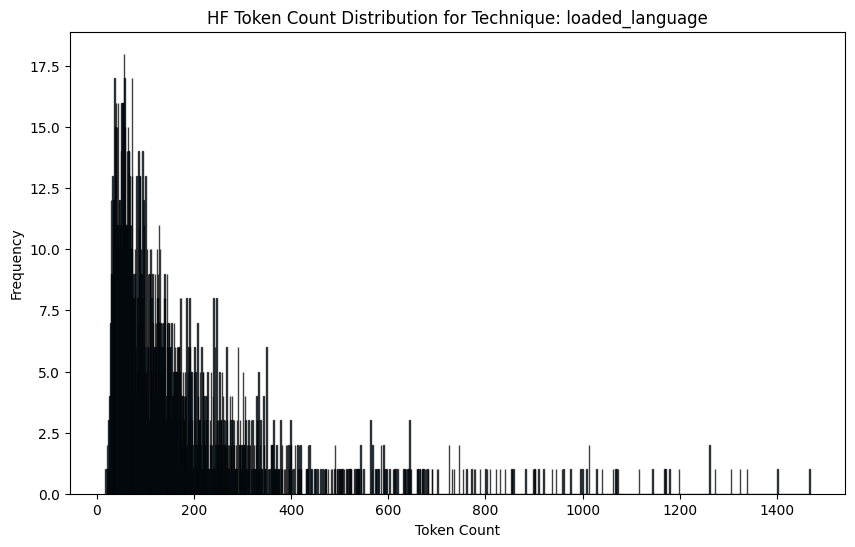

<Figure size 1000x600 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  31.,   32.,   33., ..., 1322., 1323., 1324.]),
 <BarContainer object of 1293 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: straw_man')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

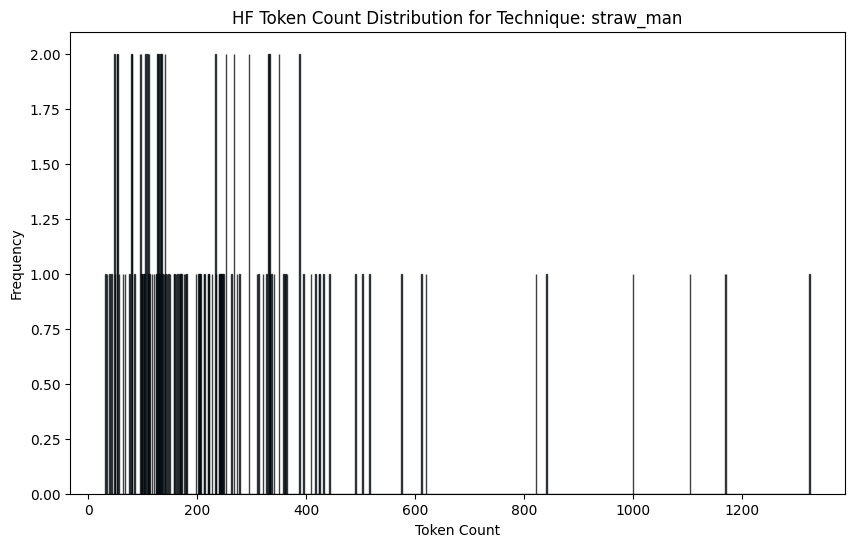

<Figure size 1000x600 with 0 Axes>

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([  26.,   27.,   28., ..., 1399., 1400., 1401.]),
 <BarContainer object of 1375 artists>)

Text(0.5, 1.0, 'HF Token Count Distribution for Technique: whataboutism')

Text(0.5, 0, 'Token Count')

Text(0, 0.5, 'Frequency')

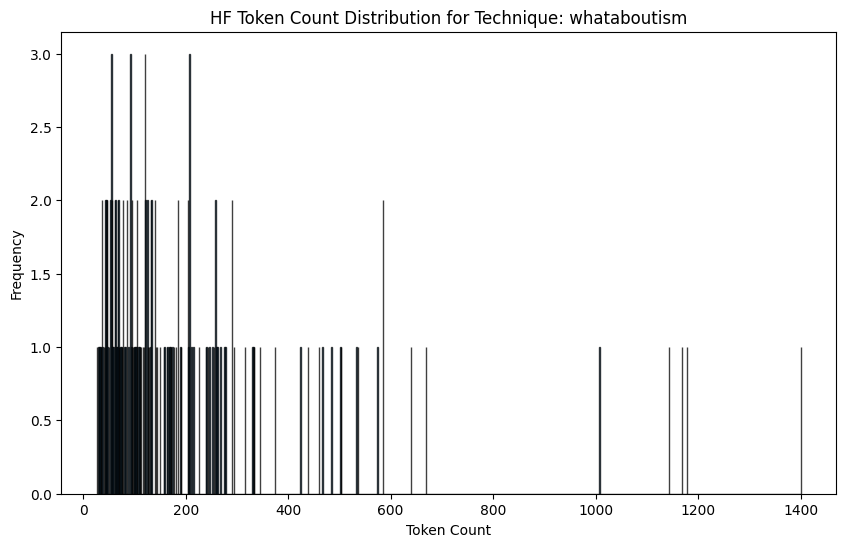

In [23]:
# Load the tokenizer (model_name should be defined, e.g., "youscan/ukr-roberta-base")

# Compute token count for each row based on 'clean_content'
df['hf_token_count'] = df['clean_content'].apply(lambda x: len(tokenizer.tokenize(x)))

# For each technique, filter rows where that technique appears and plot token count distribution
for technique in technique_list:
    # Filter rows where the "techniques" column (assumed to be a list) contains the current technique.
    subset = df[df['techniques'].apply(lambda techs: technique in techs if isinstance(techs, np.ndarray) else False)]
    if subset.empty:
        print(f"No samples found for technique: {technique}")
        continue

    plt.figure(figsize=(10, 6))
    min_count = int(subset['hf_token_count'].min())
    max_count = int(subset['hf_token_count'].max())
    bins = range(min_count, max_count + 2)
    plt.hist(subset['hf_token_count'], bins=bins, alpha=0.75, edgecolor='black')
    plt.title(f"HF Token Count Distribution for Technique: {technique}")
    plt.xlabel("Token Count")
    plt.ylabel("Frequency")
    plt.show()


In [24]:
skip_token_analysis = True

In [25]:
%%skip_if skip_token_analysis

# Define tokenizers to compare.
# Uncomment or add additional tokenizers as needed.
tokenizer_dict = {
    "roberta_base_ukrainian_upos": AutoTokenizer.from_pretrained("KoichiYasuoka/roberta-base-ukrainian-upos"),
    "uk_ner": AutoTokenizer.from_pretrained("ukr-models/uk-ner"),
    #"llama2_ukrainian": AutoTokenizer.from_pretrained("tartuNLP/Llama-2-7b-Ukrainian"),
    "uk_summarizer": AutoTokenizer.from_pretrained("ukr-models/uk-summarizer"),
    "youscan_ukr_roberta": AutoTokenizer.from_pretrained("youscan/ukr-roberta-base"),
    "ukr_xlm_roberta_base_uk": AutoTokenizer.from_pretrained("ukr-models/xlm-roberta-base-uk"),
}

# (Optional) Print each tokenizer's unknown token id.
for name, tok in tokenizer_dict.items():
    print(f"{name} unk_token_id: {tok.unk_token_id}")

df_test = df.copy(deep=True)

def compare_tokenizers(text, lang):
    results = {}
    for name, tok in tokenizer_dict.items():
        # Encode text (with special tokens) and convert back to tokens.
        token_ids = tok.encode(text, add_special_tokens=True)
        tokens = tok.convert_ids_to_tokens(token_ids)
        unk_id = tok.unk_token_id
        unk_count = token_ids.count(unk_id)
        total_tokens = len(token_ids)
        unk_ratio = unk_count / total_tokens if total_tokens > 0 else 0

        # Save results with a key prefix based on tokenizer name.
        results[f"{name}_tokens"] = tokens
        results[f"{name}_total_tokens"] = total_tokens
        results[f"{name}_unk_count"] = unk_count
        results[f"{name}_unk_ratio"] = unk_ratio
    return pd.Series(results)

# Apply the comparison function to each row.
df_stats = df_test.apply(lambda row: compare_tokenizers(row['clean_content'], row['lang']), axis=1)
df_test = pd.concat([df_test, df_stats], axis=1)

# Calculate average unknown ratio for each tokenizer across the dataset.
averages = {}
for name in tokenizer_dict.keys():
    avg_ratio = df_test[f"{name}_unk_ratio"].mean()
    averages[name] = avg_ratio

print("\nAverage Unknown Token Ratio per Tokenizer:")
for name, avg in averages.items():
    print(f"{name}: {avg}")

# Display selected columns with tokenization results.
columns_to_display = ['content', 'lang']
for name in tokenizer_dict.keys():
    columns_to_display.extend([
        f"{name}_tokens",
        f"{name}_total_tokens",
        f"{name}_unk_count",
        f"{name}_unk_ratio"
    ])

print("\nTokenization Unknown Analysis:")
df_test[columns_to_display]

In [26]:
%%skip_if skip_token_analysis
df_test['youscan_ukr_roberta_total_tokens'].describe()

# Model development

In [27]:
# Apply cleaning to the 'content' column and create a new column 'clean_content'
df['clean_content'] = df['content'].apply(clean_text)

# Show an example of cleaned content
print("Example of Cleaned Content (Row 0):")
print(df.loc[0, 'clean_content'])


Example of Cleaned Content (Row 0):
Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду та ректора музичної академії міноборони рф Євгєнія Пригожина. Пригожин прогнозує, що невдовзі настане день звільнення Криму і день розпаду росії. Каже, що передумови цього вже створені. *Відео взяли з каналу ФД . @informnapalm


In [28]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Test the tokenizer on the cleaned text from the first row
sample_text = df.loc[0, 'clean_content']
print("Sample text:")
print(sample_text)


Sample text:
Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду та ректора музичної академії міноборони рф Євгєнія Пригожина. Пригожин прогнозує, що невдовзі настане день звільнення Криму і день розпаду росії. Каже, що передумови цього вже створені. *Відео взяли з каналу ФД . @informnapalm


In [29]:
# Tokenize the sample text
tokens = tokenizer.tokenize(sample_text)
print("Tokenized output (list of tokens):")
print(tokens)

# Reconstruct a human-readable string from tokens
reconstructed = tokenizer.convert_tokens_to_string(tokens)
print("Reconstructed text from tokens:")
print(reconstructed)

Tokenized output (list of tokens):
['ÐĿÐ¾Ð²Ð¸Ð¹', 'ĠÐ¾Ð³Ð»ÑıÐ´', 'ĠÐ¼Ð°', 'Ð¿Ð¸', 'ĠDe', 'ep', 'St', 'ate', 'ĠÐ²ÑĸÐ´', 'ĠÑĢÐ¾ÑģÑĸÐ¹ÑģÑĮÐºÐ¾Ð³Ð¾', 'ĠÐ²ÑĸÐ¹ÑģÑĮÐºÐ¾Ð²Ð¾Ð³Ð¾', 'ĠÐµÐºÑģÐ¿ÐµÑĢÑĤÐ°', ',', 'ĠÐºÑĥÑħ', 'Ð°ÑĢÐ°', 'ĠÐ¿Ñĥ', 'ÑĤÑĸÐ½Ð°', 'Ġ2', 'ĠÑĢÐ¾Ð·ÑĢÑıÐ´Ñĥ', ',', 'ĠÑģÐ¿ÐµÑĨÑĸÐ°Ð»ÑĸÑģÑĤÐ°', 'ĠÐ¿Ð¾', 'ĠÑģÐ½Ð°ÑĢÑıÐ´', 'Ð½Ð¾Ð¼Ñĥ', 'ĠÐ³Ð¾Ð»Ð¾Ð´Ñĥ', 'ĠÑĤÐ°', 'ĠÑĢÐµÐºÑĤÐ¾ÑĢÐ°', 'ĠÐ¼ÑĥÐ·Ð¸ÑĩÐ½Ð¾ÑĹ', 'ĠÐ°ÐºÐ°Ð´ÐµÐ¼ÑĸÑĹ', 'ĠÐ¼ÑĸÐ½', 'Ð¾Ð±Ð¾ÑĢÐ¾Ð½Ð¸', 'ĠÑĢ', 'ÑĦ', 'ĠÐĦÐ²', 'Ð³', 'ÑĶ', 'Ð½ÑĸÑı', 'ĠÐŁÑĢÐ¸', 'Ð³', 'Ð¾Ð¶Ð¸', 'Ð½Ð°', '.', 'ĠÐŁÑĢÐ¸', 'Ð³', 'Ð¾Ð¶Ð¸', 'Ð½', 'ĠÐ¿ÑĢÐ¾Ð³Ð½Ð¾Ð·ÑĥÑĶ', ',', 'ĠÑīÐ¾', 'ĠÐ½ÐµÐ²Ð´Ð¾Ð²Ð·Ñĸ', 'ĠÐ½Ð°ÑģÑĤÐ°Ð½Ðµ', 'ĠÐ´ÐµÐ½ÑĮ', 'ĠÐ·Ð²ÑĸÐ»ÑĮÐ½ÐµÐ½Ð½Ñı', 'ĠÐļÑĢÐ¸Ð¼Ñĥ', 'ĠÑĸ', 'ĠÐ´ÐµÐ½ÑĮ', 'ĠÑĢÐ¾Ð·Ð¿Ð°Ð´Ñĥ', 'ĠÑĢÐ¾', 'ÑģÑĸÑĹ', '.', 'ĠÐļÐ°Ð¶Ðµ', ',', 'ĠÑīÐ¾', 'ĠÐ¿ÐµÑĢÐµÐ´ÑĥÐ¼Ð¾Ð²Ð¸', 'ĠÑĨÑĮÐ¾Ð³Ð¾', 'ĠÐ²Ð¶Ðµ', 'ĠÑģÑĤÐ²Ð¾ÑĢÐµÐ½Ñĸ', '.', 'Ġ*', 'ÐĴÑĸÐ´ÐµÐ¾', 'ĠÐ²Ð·ÑıÐ»Ð¸', 'ĠÐ·', 'ĠÐºÐ°Ð½Ð°Ð»Ñĥ', 'ĠÐ¤', 'ÐĶ', 'Ġ.', 'Ġ@', 'inform', 'nap', 'al', 'm']
Reconstructed text fro

In [30]:
# Define a tokenization function using the Hugging Face tokenizer
def hf_tokenize(text):
    # Tokenize the cleaned text using the pretrained Ukrainian tokenizer
    tokens = tokenizer.tokenize(text)
    return tokens

# Apply the Hugging Face tokenization to the cleaned content
df['hf_tokens'] = df['clean_content'].apply(hf_tokenize)
df['hf_token_count'] = df['hf_tokens'].apply(len)

# Show token count statistics
print("Token Count Statistics (Hugging Face Tokenizer):")
print(df['hf_token_count'].describe())

# Display an example of tokenized content for the first row
print("\nHugging Face Tokens in Row 0:")
print(df.loc[0, 'hf_tokens'])


Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors


Token Count Statistics (Hugging Face Tokenizer):
count    3822.000000
mean      164.577185
std       166.490375
min        18.000000
25%        63.000000
50%       115.000000
75%       195.750000
max      1466.000000
Name: hf_token_count, dtype: float64

Hugging Face Tokens in Row 0:
['ÐĿÐ¾Ð²Ð¸Ð¹', 'ĠÐ¾Ð³Ð»ÑıÐ´', 'ĠÐ¼Ð°', 'Ð¿Ð¸', 'ĠDe', 'ep', 'St', 'ate', 'ĠÐ²ÑĸÐ´', 'ĠÑĢÐ¾ÑģÑĸÐ¹ÑģÑĮÐºÐ¾Ð³Ð¾', 'ĠÐ²ÑĸÐ¹ÑģÑĮÐºÐ¾Ð²Ð¾Ð³Ð¾', 'ĠÐµÐºÑģÐ¿ÐµÑĢÑĤÐ°', ',', 'ĠÐºÑĥÑħ', 'Ð°ÑĢÐ°', 'ĠÐ¿Ñĥ', 'ÑĤÑĸÐ½Ð°', 'Ġ2', 'ĠÑĢÐ¾Ð·ÑĢÑıÐ´Ñĥ', ',', 'ĠÑģÐ¿ÐµÑĨÑĸÐ°Ð»ÑĸÑģÑĤÐ°', 'ĠÐ¿Ð¾', 'ĠÑģÐ½Ð°ÑĢÑıÐ´', 'Ð½Ð¾Ð¼Ñĥ', 'ĠÐ³Ð¾Ð»Ð¾Ð´Ñĥ', 'ĠÑĤÐ°', 'ĠÑĢÐµÐºÑĤÐ¾ÑĢÐ°', 'ĠÐ¼ÑĥÐ·Ð¸ÑĩÐ½Ð¾ÑĹ', 'ĠÐ°ÐºÐ°Ð´ÐµÐ¼ÑĸÑĹ', 'ĠÐ¼ÑĸÐ½', 'Ð¾Ð±Ð¾ÑĢÐ¾Ð½Ð¸', 'ĠÑĢ', 'ÑĦ', 'ĠÐĦÐ²', 'Ð³', 'ÑĶ', 'Ð½ÑĸÑı', 'ĠÐŁÑĢÐ¸', 'Ð³', 'Ð¾Ð¶Ð¸', 'Ð½Ð°', '.', 'ĠÐŁÑĢÐ¸', 'Ð³', 'Ð¾Ð¶Ð¸', 'Ð½', 'ĠÐ¿ÑĢÐ¾Ð³Ð½Ð¾Ð·ÑĥÑĶ', ',', 'ĠÑīÐ¾', 'ĠÐ½ÐµÐ²Ð´Ð¾Ð²Ð·Ñĸ', 'ĠÐ½Ð°ÑģÑĤÐ°Ð½Ðµ', 'ĠÐ´ÐµÐ½ÑĮ', 'ĠÐ·Ð²ÑĸÐ»ÑĮÐ½ÐµÐ½Ð½Ñı', 'ĠÐļÑĢÐ¸Ð¼Ñĥ', 'ĠÑĸ', 'ĠÐ´ÐµÐ½ÑĮ', 'ĠÑĢÐ¾Ð·Ð¿Ð°Ð´Ñĥ', 'ĠÑĢÐ¾', 'Ñģ

In [31]:
# For reproducibility
# stratification sklearn?
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))


Training samples: 3057
Validation samples: 765


In [32]:
def parse_techniques(techniques):
    if techniques is None:
        return []
    if isinstance(techniques, str):
        if techniques.strip() == "":
            return []
        try:
            return ast.literal_eval(techniques)
        except Exception as e:
            print("Error parsing techniques:", techniques, e)
            return []
    # If techniques is already an iterable (e.g., list or numpy array), convert it to a list.
    try:
        return list(techniques)
    except TypeError:
        return techniques

df['techniques_parsed'] = df['techniques'].apply(parse_techniques)

# Dynamically compute the full set of techniques from the training set.
all_techniques = set()
for tech_list in df['techniques_parsed']:
    all_techniques.update(tech_list)
all_techniques = sorted(all_techniques)  # Sorted order for consistency

# Initialize the MultiLabelBinarizer with the full set of techniques.
mlb = MultiLabelBinarizer(classes=all_techniques)

# Fit and transform the training set; transform the validation set.
labels = mlb.fit_transform(df['techniques_parsed'])

# Add the binary label vectors as a new column ('labels') in the DataFrames.
df['labels_vector'] = list(labels)

# Inspect a sample.
print("Sample multilabel vector from training set:", df.iloc[0]['labels_vector'])
df[['techniques', 'labels_vector']]

Sample multilabel vector from training set: [0 0 0 0 1 0 0 1 0 0]


,techniques,labels_vector
0,"[euphoria, loaded_language]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
1,"[loaded_language, cherry_picking]","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
2,"[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
3,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,[loaded_language],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
...,...,...
3817,"[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
3818,[loaded_language],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3819,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3820,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [33]:
# Initialize the stratified splitter; here we use a 80/20 split.
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the train and test indices
for train_idx, test_idx in msss.split(df, labels):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[test_idx].reset_index(drop=True)
# Now df_train and df_test preserve the multilabel distribution across splits.
print("Training set size:", len(train_df))
print("Test set size:", len(val_df))

Training set size: 3057
Test set size: 765


In [34]:
train_df

,id,content,lang,manipulative,techniques,trigger_words,clean_content,words_count,trigger_words_text,hf_token_count,hf_tokens,techniques_parsed,labels_vector
0,0bb0c7fa-101b-4583-a5f9-9d503339141c,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",uk,True,"[euphoria, loaded_language]","[[27, 63], [65, 88], [90, 183], [186, 308]]","Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",49,"[від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду...",81,"[ÐĿÐ¾Ð²Ð¸Ð¹, ĠÐ¾Ð³Ð»ÑıÐ´, ĠÐ¼Ð°, Ð¿Ð¸, ĠDe, ep, St, ate, ĠÐ²ÑĸÐ´, ĠÑĢÐ¾ÑģÑĸÐ¹ÑģÑĮÐºÐ¾Ð³Ð¾, ĠÐ²Ñĸ...","[euphoria, loaded_language]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
1,e6a427f1-211f-405f-bd8b-70798458d656,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,uk,True,"[loaded_language, euphoria]","[[55, 100]]",🤩 Тим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні пр...,36,[він оточений з невідомих простій русні причин],61,"[ðŁ¤©, ĠÐ¢Ð¸Ð¼, ĠÑĩÐ°ÑģÐ¾Ð¼, ĠÐ¹Ð´Ðµ, ĠÐµÐ²Ð°ÐºÑĥ, Ð°ÑĨÑĸÑı, ĠÐĳÑĶ, Ð», Ð³Ð¾ÑĢÐ¾Ð´, ÑģÑĮÐºÐ¾Ð³Ð¾...","[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]"
2,1647a352-4cd3-40f6-bfa1-d87d42e34eea,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,uk,False,None,None,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,124,None,152,"[ÐĴ, ĠÐ£ÐºÑĢÐ°ÑĹÐ½Ñĸ, ĠÐ½Ð°Ð¹Ð±Ð»Ð¸Ð¶ÑĩÐ¸Ð¼, ĠÑĩÐ°ÑģÐ¾Ð¼, ĠÐ¼Ð°ÑİÑĤÑĮ, ĠÐ½Ð°Ð¼ÑĸÑĢ, ĠÐ¿Ð¾ÑģÐ¸Ð»Ð...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1417fffa-461c-4bf7-bea5-398e8ea5db81,"⚡️\nКитай надеется, что пакетное соглашение о транспортировке зерна по Чёрному морю будет и дале...",ru,False,None,None,"⚡️ Китай надеется, что пакетное соглашение о транспортировке зерна по Чёрному морю будет и далее...",21,None,45,"[âļ, ¡ï¸ı, ĠÐļÐ¸ÑĤÐ°Ð¹, ĠÐ½Ð°, Ð´Ðµ, ÐµÑĤÑģÑı, ,, ĠÑĩÑĤÐ¾, ĠÐ¿Ð°ÐºÐµÑĤ, Ð½Ð¾Ðµ, ĠÑģ, Ð¾Ð³, Ð»Ð°,...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,f8021666-1636-4e1f-b8e3-535860eca5ce,"До сьогоднішнього дня Джо Байден був у Києві понад 8 років тому. Та попри очевидні ризики, прези...",uk,True,"[loaded_language, glittering_generalities, euphoria]","[[65, 223], [225, 697]]","До сьогоднішнього дня Джо Байден був у Києві понад 8 років тому. Та попри очевидні ризики, прези...",108,"[Та попри очевидні ризики, президент США та лідер демократичного світу приїжджає у вільну країну...",143,"[ÐĶÐ¾, ĠÑģÑĮÐ¾Ð³Ð¾Ð´Ð½ÑĸÑĪÐ½ÑĮÐ¾Ð³Ð¾, ĠÐ´Ð½Ñı, ĠÐĶÐ¶Ð¾, ĠÐĳÐ°Ð¹, Ð´ÐµÐ½, ĠÐ±ÑĥÐ², ĠÑĥ, ĠÐļÐ¸ÑĶÐ²...","[loaded_language, glittering_generalities, euphoria]","[0, 0, 0, 0, 1, 0, 1, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,423230c2-625a-4de2-ba66-57ebdb1a798e,Наш символ гордості та сили.\nНашої стійкості та незламності. \nЦе наша ВОЛЯ об’єднана в один зн...,uk,True,"[glittering_generalities, cliche]","[[0, 97], [302, 358], [360, 405]]",Наш символ гордості та сили. Нашої стійкості та незламності. Це наша ВОЛЯ об’єднана в один знак....,64,[Наш символ гордості та сили.\nНашої стійкості та незламності. \nЦе наша ВОЛЯ об’єднана в один з...,103,"[ÐĿÐ°ÑĪ, ĠÑģÐ¸Ð¼Ð²Ð¾Ð», ĠÐ³Ð¾ÑĢÐ´Ð¾ÑģÑĤÑĸ, ĠÑĤÐ°, ĠÑģÐ¸Ð»Ð¸, ., ĠÐĿÐ°, ÑĪÐ¾ÑĹ, ĠÑģÑĤÑĸÐ¹ÐºÐ¾ÑģÑĤ...","[glittering_generalities, cliche]","[0, 0, 0, 1, 0, 0, 1, 0, 0, 0]"
3053,0e5dd135-ef41-48d3-b274-faedf3a2126c,"🤭\nросія ставить ППО на дахах адмінбудівель\nросійське керівництво перелякане, що військова пром...",uk,True,"[loaded_language, euphoria]","[[2, 7], [43, 75], [77, 143], [145, 178], [340, 385], [492, 526], [540, 571]]","🤭 росія ставить ППО на дахах адмінбудівель російське керівництво перелякане, що військова промис...",82,"[росія, російське керівництво перелякане, що військова промисловість нашої держави може виготови...",116,"[ðŁ¤, Ń, ĠÑĢÐ¾ÑģÑĸÑı, ĠÑģÑĤÐ°Ð²Ð¸ÑĤÑĮ, ĠÐŁ, ÐŁÐŀ, ĠÐ½Ð°, ĠÐ´Ð°Ñħ, Ð°Ñħ, ĠÐ°Ð´Ð¼ÑĸÐ½, Ð±ÑĥÐ´ÑĸÐ²Ð...","[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 

In [35]:
train_df_augmented = pd.read_parquet('./data/train_augmented.parquet')
train_df_augmented

,id,content,lang,manipulative,techniques,trigger_words,clean_content,words_count,trigger_words_text,hf_token_count,hf_tokens,techniques_parsed,labels_vector,needs_augmentation
0,0bb0c7fa-101b-4583-a5f9-9d503339141c,"Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",uk,True,"[euphoria, loaded_language]","[[27, 63], [65, 88], [90, 183], [186, 308]]","Новий огляд мапи DeepState від російського військового експерта, кухара путіна 2 розряду, спеціа...",49,"[від російського військового експерта, кухара путіна 2 розряду, спеціаліста по снарядному голоду...",81,"[ÐĿÐ¾Ð²Ð¸Ð¹, ĠÐ¾Ð³Ð»ÑıÐ´, ĠÐ¼Ð°, Ð¿Ð¸, ĠDe, ep, St, ate, ĠÐ²ÑĸÐ´, ĠÑĢÐ¾ÑģÑĸÐ¹ÑģÑĮÐºÐ¾Ð³Ð¾, ĠÐ²Ñĸ...","[euphoria, loaded_language]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]",False
1,e6a427f1-211f-405f-bd8b-70798458d656,🤩\nТим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні п...,uk,True,"[loaded_language, euphoria]","[[55, 100]]",🤩 Тим часом йде евакуація Бєлгородського автовокзалу - він оточений з невідомих простій русні пр...,36,[він оточений з невідомих простій русні причин],61,"[ðŁ¤©, ĠÐ¢Ð¸Ð¼, ĠÑĩÐ°ÑģÐ¾Ð¼, ĠÐ¹Ð´Ðµ, ĠÐµÐ²Ð°ÐºÑĥ, Ð°ÑĨÑĸÑı, ĠÐĳÑĶ, Ð», Ð³Ð¾ÑĢÐ¾Ð´, ÑģÑĮÐºÐ¾Ð³Ð¾...","[loaded_language, euphoria]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]",False
2,1647a352-4cd3-40f6-bfa1-d87d42e34eea,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,uk,False,None,None,В Україні найближчим часом мають намір посилити відповідальність за ухилення від мобілізації та ...,124,None,152,"[ÐĴ, ĠÐ£ÐºÑĢÐ°ÑĹÐ½Ñĸ, ĠÐ½Ð°Ð¹Ð±Ð»Ð¸Ð¶ÑĩÐ¸Ð¼, ĠÑĩÐ°ÑģÐ¾Ð¼, ĠÐ¼Ð°ÑİÑĤÑĮ, ĠÐ½Ð°Ð¼ÑĸÑĢ, ĠÐ¿Ð¾ÑģÐ¸Ð»Ð...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",False
3,1417fffa-461c-4bf7-bea5-398e8ea5db81,"⚡️\nКитай надеется, что пакетное соглашение о транспортировке зерна по Чёрному морю будет и дале...",ru,False,None,None,"⚡️ Китай надеется, что пакетное соглашение о транспортировке зерна по Чёрному морю будет и далее...",21,None,45,"[âļ, ¡ï¸ı, ĠÐļÐ¸ÑĤÐ°Ð¹, ĠÐ½Ð°, Ð´Ðµ, ÐµÑĤÑģÑı, ,, ĠÑĩÑĤÐ¾, ĠÐ¿Ð°ÐºÐµÑĤ, Ð½Ð¾Ðµ, ĠÑģ, Ð¾Ð³, Ð»Ð°,...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",False
4,f8021666-1636-4e1f-b8e3-535860eca5ce,"До сьогоднішнього дня Джо Байден був у Києві понад 8 років тому. Та попри очевидні ризики, прези...",uk,True,"[loaded_language, glittering_generalities, euphoria]","[[65, 223], [225, 697]]","До сьогоднішнього дня Джо Байден був у Києві понад 8 років тому. Та попри очевидні ризики, прези...",108,"[Та попри очевидні ризики, президент США та лідер демократичного світу приїжджає у вільну країну...",143,"[ÐĶÐ¾, ĠÑģÑĮÐ¾Ð³Ð¾Ð´Ð½ÑĸÑĪÐ½ÑĮÐ¾Ð³Ð¾, ĠÐ´Ð½Ñı, ĠÐĶÐ¶Ð¾, ĠÐĳÐ°Ð¹, Ð´ÐµÐ½, ĠÐ±ÑĥÐ², ĠÑĥ, ĠÐļÐ¸ÑĶÐ²...","[loaded_language, glittering_generalities, euphoria]","[0, 0, 0, 0, 1, 0, 1, 1, 0, 0]",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3780,b5abcbd3-b641-438d-b132-90a91f248b5d,"Звісно, що Туреччина отримує вигоду від війни рф проти України. Було б дивно, якби держава в так...",uk,True,"[loaded_language, cliche, fud, cherry_picking]","[[0, 470], [512, 609]]","Звичайно, Туреччина отримує вигоду від війни з дефекацією в Україні, і це було б дивно, якщо дер...",99,"[Звісно, що Туреччина отримує вигоду від війни рф проти України. Було б дивно, якби держава в та...",138,"[ÐĹÐ²ÑĸÑģÐ½Ð¾, ,, ĠÑīÐ¾, ĠÐ¢ÑĥÑĢÐµÑĩÑĩÐ¸Ð½Ð°, ĠÐ¾ÑĤÑĢÐ¸Ð¼ÑĥÑĶ, ĠÐ²Ð¸Ð³Ð¾Ð´Ñĥ, ĠÐ²ÑĸÐ´, ĠÐ²ÑĸÐ¹Ð½...","[loaded_language, cliche, fud, cherry_picking]","[0, 0, 1, 1, 0, 1, 0, 1, 0, 0]",True
3781,39e62017-6555-4afb-b66b-0e991f26f703,рососія планує чергову хвилю могілізації і наступ з метою захоплення нових територій України\nЗа...,uk,True,"[loaded_language, appeal_to_fear]","[[0, 92], [390, 449], [513, 541]]","Розосія планує нову хвилю міграції і наступу, щоб захопити нові території, згідно з ҐУРІ, агресо...",81,"[рососія планує чергову хвилю могілізації і наступ з метою захоплення нових територій України, в...",116,"[ÑĢÐ¾Ñģ, Ð¾Ñģ, ÑĸÑı, ĠÐ¿Ð»Ð°Ð½ÑĥÑĶ, ĠÑĩÐµÑĢÐ³Ð¾Ð²Ñĥ, ĠÑħÐ²Ð¸Ð»Ñİ, ĠÐ¼Ð¾Ð³, Ñĸ, Ð»Ñĸ, Ð·Ð°ÑĨÑĸÑĹ,...","[loaded_la

In [36]:
%%skip_if train_df_augmented is not None

import pandas as pd
from tqdm import tqdm
from datasets import Dataset, concatenate_datasets
from transformers import AutoTokenizer, MarianMTModel, MarianTokenizer
import torch

# Set device to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Step 1. Identify Minority Labels ===
label_counts = df_exploded['techniques'].value_counts().to_dict()
threshold = 400  # Adjust threshold as needed.
minority_labels = {label for label, count in label_counts.items() if count < threshold}
print("Minority labels:", minority_labels)

# Mark rows that need augmentation.
def needs_augmentation(techs):
    if techs is None:
        return False
    try:
        return any(label in minority_labels for label in list(techs))
    except TypeError:
        return False

train_df['needs_augmentation'] = train_df['techniques'].apply(needs_augmentation)

# === Step 2. Set Up Backtranslation Models ===

# For Ukrainian <-> English
uk_en_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-uk-en")
uk_en_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-uk-en").to(device)
en_uk_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-uk")
en_uk_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-uk").to(device)

# For Russian <-> English
ru_en_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
ru_en_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(device)
en_ru_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
en_ru_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-ru").to(device)

def batch_backtranslate_uk(texts):
    # Ukrainian -> English
    batch = uk_en_tokenizer(texts, return_tensors="pt", padding="max_length",
                             truncation=True)
    batch = {k: v.to(device) for k, v in batch.items()}
    generated = uk_en_model.generate(**batch)
    english_texts = [uk_en_tokenizer.decode(t, skip_special_tokens=True) for t in generated]

    # English -> Ukrainian
    batch = en_uk_tokenizer(english_texts, return_tensors="pt", padding="max_length",
                             truncation=True)
    batch = {k: v.to(device) for k, v in batch.items()}
    generated = en_uk_model.generate(**batch)
    back_texts = [en_uk_tokenizer.decode(t, skip_special_tokens=True) for t in generated]
    return back_texts

def batch_backtranslate_ru(texts):
    # Russian -> English
    batch = ru_en_tokenizer(texts, return_tensors="pt", padding="max_length",
                             truncation=True)
    batch = {k: v.to(device) for k, v in batch.items()}
    generated = ru_en_model.generate(**batch)
    english_texts = [ru_en_tokenizer.decode(t, skip_special_tokens=True) for t in generated]

    # English -> Russian
    batch = en_ru_tokenizer(english_texts, return_tensors="pt", padding="max_length",
                             truncation=True)
    batch = {k: v.to(device) for k, v in batch.items()}
    generated = en_ru_model.generate(**batch)
    back_texts = [en_ru_tokenizer.decode(t, skip_special_tokens=True) for t in generated]
    return back_texts

# === Step 3. Batch Augmentation ===
# Filter rows needing augmentation.
df_to_aug = train_df[train_df['needs_augmentation']].copy()

# Split based on language.
df_ru = df_to_aug[df_to_aug['lang'].str.lower() == 'ru'].copy()
df_uk = df_to_aug[df_to_aug['lang'].str.lower() != 'ru'].copy()

batch_size = 2  # Adjust batch size based on your GPU memory.

def process_batches(df, batch_func):
    texts = df['clean_content'].tolist()
    augmented_texts = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Batch processing"):
        batch_texts = texts[i:i+batch_size]
        augmented_texts.extend(batch_func(batch_texts))
    return augmented_texts

if not df_ru.empty:
    augmented_ru_texts = process_batches(df_ru, batch_backtranslate_ru)
    df_ru['clean_content'] = augmented_ru_texts

if not df_uk.empty:
    augmented_uk_texts = process_batches(df_uk, batch_backtranslate_uk)
    df_uk['clean_content'] = augmented_uk_texts

# Combine the augmented samples.
augmented_df = pd.concat([df_ru, df_uk], axis=0)

# Append these augmented rows to the original DataFrame.
train_df_augmented = pd.concat([train_df, augmented_df], ignore_index=True)
print(f"Original training samples: {len(train_df)}, after augmentation: {len(train_df_augmented)}")
train_df_augmented.to_parquet('./data/train_augmented.parquet', index=False)


In [37]:
# Load the tokenizer (using the chosen Ukrainian model)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# A preprocessing function for our texts
def preprocess_classification(example):
    # Tokenize the 'clean_content'; adjust max_length as needed.
    encoding = tokenizer(example['clean_content'], truncation=True, padding="max_length", max_length=max_tokens_length)
    # Add the binary label vector
    encoding['labels'] = [float(l) for l in example['labels_vector']]
    return encoding

# Convert our pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df_augmented[['clean_content', 'labels_vector']])
val_dataset = Dataset.from_pandas(val_df[['clean_content', 'labels_vector']])

# Apply tokenization/preprocessing
train_dataset = train_dataset.map(preprocess_classification, batched=False)
val_dataset = val_dataset.map(preprocess_classification, batched=False)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
full_dataset = concatenate_datasets([train_dataset, val_dataset])
print("Example from training dataset:", train_dataset[0])

Map:   0%|          | 0/3785 [00:00<?, ? examples/s]

Map:   0%|          | 0/765 [00:00<?, ? examples/s]

Example from training dataset: {'input_ids': tensor([    0, 13612,  8817,   475,   533, 15663,  4974, 11407,  8598,   358,
         7968,  8738, 25486,    16,  6832,   629,  3234,  8919,   416, 26840,
           16, 15714,   367, 27823,   630, 15688,   342, 25944, 18985,  6407,
         4596, 16989,   615,   339,  2962,   308,   318,  4082,  1089,   308,
         2143,   326,    18,  1089,   308,  2143,   264, 47933,    16,   402,
        19830, 37081,  1631,  6299,  5069,   320,  1631, 24347,   705,  1342,
           18, 39392,    16,   402, 26299,   948,   969, 11358,    18,  6370,
        27020,  4913,   284, 10694,   758,   548,  1473,  6499, 37503, 40961,
         1245,    81,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     

### Model training

In [38]:
df_exploded = train_df_augmented.explode('techniques')
label_counts = df_exploded['techniques'].value_counts().to_dict()
total_samples = len(df['techniques'])
total_samples, label_counts

(3822,
 {'loaded_language': 2130,
  'cherry_picking': 628,
  'fud': 616,
  'cliche': 523,
  'appeal_to_fear': 480,
  'glittering_generalities': 456,
  'euphoria': 408,
  'bandwagon': 252,
  'whataboutism': 252,
  'straw_man': 220})

In [39]:
pos_weight_list = []
for label in sorted(label_counts.keys()):
    count = label_counts[label]
    neg = total_samples - count
    pos_weight = neg / count
    pos_weight_list.append(pos_weight)

pos_weight = torch.tensor(pos_weight_list, dtype=torch.float)
print("Computed pos_weight:", pos_weight)

Computed pos_weight: tensor([ 6.9625, 14.1667,  5.0860,  6.3078,  8.3676,  5.2045,  7.3816,  0.7944,
        16.3727, 14.1667])


In [40]:
class DataCollatorForMultiLabelClassification(DataCollatorWithPadding):
    def __call__(self, features):
        # Check if the first feature has the "labels" key.
        if "labels" in features[0]:
            labels = [feature.pop("labels") for feature in features]
        else:
            labels = None

        # Pad the remaining features (e.g., input_ids, attention_mask).
        batch = super().__call__(features)

        # If labels were present, stack them into a tensor.
        if labels is not None:
            batch["labels"] = torch.stack([torch.as_tensor(label, dtype=torch.float) for label in labels])
        return batch

# Instantiate the data collator with explicit padding strategy.
data_collator = DataCollatorForMultiLabelClassification(tokenizer, padding="max_length", max_length=max_tokens_length)

In [41]:
# Define a custom Trainer that uses a weighted loss.
class WeightedLossTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        # Cache the loss function once (move to device later in compute_loss if needed).
        self.cached_loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Remove the extra keyword if present.
        inputs.pop("num_items_in_batch", None)
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Move the cached loss function's pos_weight to the correct device once per batch.
        loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.cached_loss_fct.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

In [42]:
# Assume technique_list is the sorted list of labels (in the same order as above).
technique_list = sorted(label_counts.keys())
id2label = {i: label for i, label in enumerate(technique_list)}
label2id = {label: i for i, label in enumerate(technique_list)}


In [43]:
# Define a compute_metrics function (using macro F1 as an example)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Apply sigmoid to get probabilities and then threshold at 0.5
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)
    return {"macro_f1": f1_macro}

In [38]:
# Load the model (multilabel classification)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(technique_list),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id,
)

# Set up training arguments.
training_args = TrainingArguments(
    output_dir="./models/trainer_output",
    seed=42,
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,  # Increase epochs if needed
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.1,
    fp16=True,
    #load_best_model_at_end=True,
)

base_params = [p for n, p in model.named_parameters() if not n.startswith("classifier")]
head_params = [p for n, p in model.named_parameters() if n.startswith("classifier")]
optimizer = AdamW([
    {'params': base_params, 'lr': 1e-5},  # lower LR for base parameters
    {'params': head_params, 'lr': 1e-3}     # higher LR for classifier layer
], weight_decay=0.1)


# Initialize the custom Trainer.
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, None),
    compute_metrics=compute_metrics,
    pos_weight=pos_weight,
    data_collator=data_collator
)

# Start training.
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1
1,No log,0.868683,0.332341
2,1.047900,0.883525,0.379338
3,0.864300,0.876064,0.375843
4,0.703200,1.018273,0.404388
5,0.574200,1.095486,0.402887


TrainOutput(global_step=2370, training_loss=0.7499347606288733, metrics={'train_runtime': 760.6472, 'train_samples_per_second': 24.88, 'train_steps_per_second': 3.116, 'total_flos': 4979734385203200.0, 'train_loss': 0.7499347606288733, 'epoch': 5.0})

#### Threshold optimization

In [40]:
import numpy as np

def optimize_thresholds(preds_prob, true_labels, thresholds=np.arange(0.1, 0.9, 0.05)):
    best_thresholds = []
    num_labels = true_labels.shape[1]
    for label in range(num_labels):
        best_f1 = 0.0
        best_t = 0.5
        for t in thresholds:
            preds = (preds_prob[:, label] > t).astype(int)
            f1 = f1_score(true_labels[:, label], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return best_thresholds

# After training, get predictions on your validation set.
results = trainer.predict(val_dataset)
preds_prob = torch.sigmoid(torch.tensor(results.predictions)).numpy()
true_labels = results.label_ids.astype(int)

best_thresholds = optimize_thresholds(preds_prob, true_labels)
print("Optimized thresholds per class:", best_thresholds)


Optimized thresholds per class: [0.30000000000000004, 0.1, 0.3500000000000001, 0.5000000000000001, 0.6500000000000001, 0.8000000000000002, 0.7500000000000002, 0.20000000000000004, 0.30000000000000004, 0.20000000000000004]


#### Evaluation

In [62]:
predictions = trainer.predict(val_dataset)
# predictions.predictions is an array of logits.
# Convert logits to probabilities, then threshold to get binary predictions.
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()

# Create a list mapping predicted binary vectors to label names.
predicted_labels_list = []
for sample_pred in preds:
    sample_labels = [id2label[i] for i, flag in enumerate(sample_pred) if flag == 1]
    predicted_labels_list.append(sample_labels)

# Now, assume you still have your original validation DataFrame "val_df"
# with the original columns "id" and "clean_content".
# Make sure the order of rows in val_df matches the order in val_dataset.
val_ids = val_df["id"].tolist()
val_texts = val_df["clean_content"].tolist()

print("Evaluation on test data:\n")
# Iterate over each sample and print the id, clean text, actual labels, and predicted labels.
for i, sample in enumerate(val_dataset):
    sample_id = val_ids[i]
    sample_text = val_texts[i]

    # Get actual labels from the dataset sample (assuming labels are a binary vector)
    actual_label_names = [id2label[idx] for idx, val in enumerate(sample["labels"]) if val > 0.5]

    predicted_label_names = predicted_labels_list[i]

    print(f"Sample {i+1} (ID: {sample_id}):")
    print("Clean Text:", sample_text)
    print("Actual Labels:", actual_label_names)
    print("Predicted Labels:", predicted_label_names)
    print("-" * 50)
    if i > 10:
        break

Evaluation on test data:

Sample 1 (ID: 7159f802-6f99-4e9d-97bd-6f565a4a0fae):
Clean Text: Недавно 95 квартал жёстко поглумился над русскими баранами, которые притворяются украинцами. Про Скадовск там шуточки были дегенеративные. И что предлагают сделать русские бараны? Как обычно стать на колени и лизать украинскую туфлю, чтобы их простили. Украинцы же как негры, перед ними нужно бесконечно извиняться. ‼️ Мэр оккупированного Скадовска Яковлев прокомментировал номер "Квартала 95": Надеюсь, у режиссеров хватит сил извиниться Так, глава города призвал режиссеров шоу извиниться перед людьми за шутки. "Очень прав был Петлюра, который говорил: "Нам не так страшны московские вши, нам страшны украинские гниды". Шутки о "сеськах" из Скадовска, наверное, кому-то кажутся очень остроумными. Но пусть это будет на совести режиссеров. Надеюсь, у них хватит силы извиниться перед украинцами Скадовск сегодня в оккупации, и действительно чего сейчас нуждаются скадовчане в поддержке. Знаю, что у нас мног

#### F1 score

In [63]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Get predictions from your Trainer on your test dataset.
results = trainer.predict(val_dataset)
logits = results.predictions  # raw logits from the model
true_labels = results.label_ids  # true labels as a numpy array

# Convert logits to probabilities using sigmoid and then threshold to get binary predictions.
pred_probs = torch.sigmoid(torch.tensor(logits))
preds = (pred_probs > 0.5).int().numpy()

# Ensure the true labels are integer type.
true_labels = true_labels.astype(int)

# Compute per-label metrics.
precision_per_label = precision_score(true_labels, preds, average=None, zero_division=0)
recall_per_label = recall_score(true_labels, preds, average=None, zero_division=0)
f1_per_label = f1_score(true_labels, preds, average=None, zero_division=0)

# Print per-label scores.
print("Per-label metrics:")
for idx, label in id2label.items():
    print(f"Label '{label}': Precision: {precision_per_label[idx]:.4f}, Recall: {recall_per_label[idx]:.4f}, F1: {f1_per_label[idx]:.4f}")

# Compute overall metrics.
macro_precision = precision_score(true_labels, preds, average='macro', zero_division=0)
macro_recall = recall_score(true_labels, preds, average='macro', zero_division=0)
macro_f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

micro_precision = precision_score(true_labels, preds, average='micro', zero_division=0)
micro_recall = recall_score(true_labels, preds, average='micro', zero_division=0)
micro_f1 = f1_score(true_labels, preds, average='micro', zero_division=0)

print(f"\nOverall Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1: {macro_f1:.4f}")
print(f"Overall Micro Precision: {micro_precision:.4f}, Micro Recall: {micro_recall:.4f}, Micro F1: {micro_f1:.4f}")


Per-label metrics:
Label 'appeal_to_fear': Precision: 0.7160, Recall: 0.9667, F1: 0.8227
Label 'bandwagon': Precision: 0.6327, Recall: 1.0000, F1: 0.7750
Label 'cherry_picking': Precision: 0.6233, Recall: 0.8922, F1: 0.7339
Label 'cliche': Precision: 0.4146, Recall: 0.9140, F1: 0.5705
Label 'euphoria': Precision: 0.6149, Recall: 0.9891, F1: 0.7583
Label 'fud': Precision: 0.6293, Recall: 0.9481, F1: 0.7565
Label 'glittering_generalities': Precision: 0.6667, Recall: 0.9897, F1: 0.7967
Label 'loaded_language': Precision: 0.8549, Recall: 0.7013, F1: 0.7705
Label 'straw_man': Precision: 0.6279, Recall: 0.9643, F1: 0.7606
Label 'whataboutism': Precision: 0.5345, Recall: 0.9688, F1: 0.6889

Overall Macro Precision: 0.6315, Macro Recall: 0.9334, Macro F1: 0.7433
Overall Micro Precision: 0.6545, Micro Recall: 0.8540, Micro F1: 0.7411


In [64]:
from sklearn.metrics import precision_score, recall_score

def analyze_metrics_by_language(true_labels, preds, val_df, id2label, lang_col='lang'):
    """
    Splits the predictions and true labels by language and computes overall and per-label metrics.

    Args:
        true_labels (np.ndarray): Array of shape (n_samples, n_labels) with true label values.
        preds (np.ndarray): Array of shape (n_samples, n_labels) with predicted labels.
        val_df (pd.DataFrame): Validation DataFrame with a language column.
        id2label (dict): Mapping from label index to label name.
        lang_col (str): Name of the language column (default: 'lang').

    Returns:
        dict: A dictionary with overall and per-label metrics for each language.
    """
    # Reset index to ensure alignment.
    val_df = val_df.reset_index(drop=True)
    if len(val_df) != true_labels.shape[0]:
        raise ValueError("Number of rows in val_df does not match number of predictions.")

    # Create boolean masks for Russian and Ukrainian.
    mask_ru = val_df[lang_col].str.lower() == 'ru'
    mask_uk = val_df[lang_col].str.lower() == 'uk'

    results = {}
    for lang, mask in zip(["ru", "uk"], [mask_ru, mask_uk]):
        true_lang = true_labels[mask.values]
        preds_lang = preds[mask.values]

        print(f"\n=== Results for language: {lang.upper()} ===")
        # Overall metrics.
        macro_precision = precision_score(true_lang, preds_lang, average='macro', zero_division=0)
        macro_recall = recall_score(true_lang, preds_lang, average='macro', zero_division=0)
        macro_f1 = f1_score(true_lang, preds_lang, average='macro', zero_division=0)
        micro_precision = precision_score(true_lang, preds_lang, average='micro', zero_division=0)
        micro_recall = recall_score(true_lang, preds_lang, average='micro', zero_division=0)
        micro_f1 = f1_score(true_lang, preds_lang, average='micro', zero_division=0)

        print(f"Overall Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1: {macro_f1:.4f}")
        print(f"Overall Micro Precision: {micro_precision:.4f}, Micro Recall: {micro_recall:.4f}, Micro F1: {micro_f1:.4f}")

        # Per-label metrics.
        precision_per_label = precision_score(true_lang, preds_lang, average=None, zero_division=0)
        recall_per_label = recall_score(true_lang, preds_lang, average=None, zero_division=0)
        f1_per_label = f1_score(true_lang, preds_lang, average=None, zero_division=0)

        print("\nPer-label metrics:")
        for idx, label in id2label.items():
            print(f"Label '{label}': Precision: {precision_per_label[idx]:.4f}, "
                  f"Recall: {recall_per_label[idx]:.4f}, F1: {f1_per_label[idx]:.4f}")

        results[lang] = {
            "overall": {
                "macro_precision": macro_precision,
                "macro_recall": macro_recall,
                "macro_f1": macro_f1,
                "micro_precision": micro_precision,
                "micro_recall": micro_recall,
                "micro_f1": micro_f1,
            },
            "per_label": {
                "precision": precision_per_label,
                "recall": recall_per_label,
                "f1": f1_per_label,
            }
        }
    return results

analyze_metrics_by_language(true_labels, preds, val_df, id2label, lang_col='lang')

Russian subset: Macro F1: 0.7496, Micro F1: 0.7519
Ukrainian subset: Macro F1: 0.7396, Micro F1: 0.7269


{'ru': {'macro_f1': 0.7496374114595334, 'micro_f1': 0.7519025875190258},
 'uk': {'macro_f1': 0.7396184033193423, 'micro_f1': 0.7269116186693148}}

### F1 score with optimized thresholds

In [41]:
import torch
import numpy as np
from sklearn.metrics import f1_score

# Get predictions from your Trainer on your validation/test dataset.
results = trainer.predict(val_dataset)
logits = results.predictions  # raw logits from the model
true_labels = results.label_ids.astype(int)  # true labels as a numpy array

# Convert logits to probabilities.
pred_probs = torch.sigmoid(torch.tensor(logits)).numpy()

# Use best_thresholds to generate predictions.
# best_thresholds is a list containing a threshold for each label.
# We'll create a new predictions array using these thresholds.
preds = np.zeros_like(pred_probs, dtype=int)
for i, threshold in enumerate(best_thresholds):
    preds[:, i] = (pred_probs[:, i] > threshold).astype(int)

# Compute per-label metrics.
precision_per_label = precision_score(true_labels, preds, average=None, zero_division=0)
recall_per_label = recall_score(true_labels, preds, average=None, zero_division=0)
# Compute F1 scores for each label individually.
f1_per_label = f1_score(true_labels, preds, average=None, zero_division=0)

# Print per-label scores.
print("Per-label metrics:")
for idx, label in id2label.items():
    print(f"Label '{label}': Precision: {precision_per_label[idx]:.4f}, Recall: {recall_per_label[idx]:.4f}, F1: {f1_per_label[idx]:.4f}")

# Compute overall metrics.
macro_precision = precision_score(true_labels, preds, average='macro', zero_division=0)
macro_recall = recall_score(true_labels, preds, average='macro', zero_division=0)
macro_f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

micro_precision = precision_score(true_labels, preds, average='micro', zero_division=0)
micro_recall = recall_score(true_labels, preds, average='micro', zero_division=0)
micro_f1 = f1_score(true_labels, preds, average='micro', zero_division=0)

print(f"\nOverall Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1: {macro_f1:.4f}")
print(f"Overall Micro Precision: {micro_precision:.4f}, Micro Recall: {micro_recall:.4f}, Micro F1: {micro_f1:.4f}")

Per-label metrics:
Label 'appeal_to_fear': Precision: 0.2566, Recall: 0.4833, F1: 0.3353
Label 'bandwagon': Precision: 0.1411, Recall: 0.7419, F1: 0.2371
Label 'cherry_picking': Precision: 0.3420, Recall: 0.7745, F1: 0.4745
Label 'cliche': Precision: 0.2511, Recall: 0.6344, F1: 0.3598
Label 'euphoria': Precision: 0.3913, Recall: 0.4891, F1: 0.4348
Label 'fud': Precision: 0.4848, Recall: 0.6234, F1: 0.5455
Label 'glittering_generalities': Precision: 0.5946, Recall: 0.6804, F1: 0.6346
Label 'loaded_language': Precision: 0.6613, Recall: 0.9392, F1: 0.7762
Label 'straw_man': Precision: 0.2881, Recall: 0.6071, F1: 0.3908
Label 'whataboutism': Precision: 0.1504, Recall: 0.5312, F1: 0.2345

Overall Macro Precision: 0.3561, Macro Recall: 0.6505, Macro F1: 0.4423
Overall Micro Precision: 0.4189, Micro Recall: 0.7488, Micro F1: 0.5372


In [45]:
trainer.save_model("./models/WeightedLoss-UkrRoberta-512-optimizer-tune-train-data")

# Evaluate test model

## Train on all data

In [ ]:
# Combine your training and validation datasets into one dataset.
# Load the model (multilabel classification)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(technique_list),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id,
)

In [54]:


print(f"Full dataset size: {len(full_dataset)}")

training_args = TrainingArguments(
    output_dir="./models/trainer_output",
    seed=42,
    report_to="none",
    save_strategy="epoch",
    num_train_epochs=1,  # Increase epochs if needed
    logging_strategy="steps",  # Use "steps" for step-level logging
    logging_steps=300,          # Log every 50 steps
    logging_first_step=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.1,
    #load_best_model_at_end=True,
)

base_params = [p for n, p in model.named_parameters() if not n.startswith("classifier")]
head_params = [p for n, p in model.named_parameters() if n.startswith("classifier")]
optimizer = AdamW([
    {'params': base_params, 'lr': 1e-5},  # lower LR for base parameters
    {'params': head_params, 'lr': 1e-3}     # higher LR for classifier layer
], weight_decay=0.1)

# Initialize the custom Trainer with the full dataset.
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=full_dataset,    # Using the full dataset for training.
    optimizers=(optimizer, None),
    compute_metrics=compute_metrics,
    pos_weight=pos_weight,
    data_collator=data_collator
)

# Start training.
trainer.train()


Full dataset size: 4550


Step,Training Loss
1,0.750200
300,0.554100


TrainOutput(global_step=569, training_loss=0.5108877507370679, metrics={'train_runtime': 448.343, 'train_samples_per_second': 10.148, 'train_steps_per_second': 1.269, 'total_flos': 1197241292083200.0, 'train_loss': 0.5108877507370679, 'epoch': 1.0})

In [ ]:
trainer.save_model("./models/WeightedLoss-UkrRoberta-512-full-data-not-tuned-thresholds")

## Load test dataset

In [55]:
test_df = pd.read_csv("./data/test.csv")
test_df

,id,content
0,521cd2e8-dd9f-42c4-98ba-c0c8890ff1ba,"Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл..."
1,9b2a61e4-d14e-4ff7-b304-e73d720319bf,"❗️\nКитай предлагает отдать оккупированные территории рф и прекратить войну\n, – The Wall Street..."
2,f0f1c236-80a8-4d25-b30c-a420a39be632,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте.\nКак поймаете - жоп...
3,31ea05ba-2c2b-4b84-aba7-f3cf6841b204,"⚡️\nІзраїль вперше у світі збив балістичну ракету в космосі,\n — The Telegraph. \nЦіль була випу..."
4,a79e13ec-6d9a-40b5-b54c-7f4f743a7525,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі.\nМи ж туд...
...,...,...
5730,e8e22b6d-0068-4afb-b606-4a1baa8a8d4c,Власть заблокировала мой YouTube-канал на территории Украины. \nПланируют полностью запретить Te...
5731,8b1d69b4-69ce-4e40-b4ba-dd2f370a8b6f,"Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла..."
5732,c2246217-3358-4f61-bda8-e2ec21aed5b2,👀\n \nОкремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» \nНа оф...
5733,45aa63c4-2248-4a0e-8f66-f3d23b6828ed,Крымский пропагандистский телеканал НТС признал гибель 74 моряков \nБДК «Новочеркасск»\nЕще 27 м...


## Preprocess

In [56]:
# Apply cleaning to the 'content' column and create a new column 'clean_content'
test_df['clean_content'] = test_df['content'].apply(clean_text)
test_df

,id,content,clean_content
0,521cd2e8-dd9f-42c4-98ba-c0c8890ff1ba,"Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл...","Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл..."
1,9b2a61e4-d14e-4ff7-b304-e73d720319bf,"❗️\nКитай предлагает отдать оккупированные территории рф и прекратить войну\n, – The Wall Street...","❗️ Китай предлагает отдать оккупированные территории рф и прекратить войну , – The Wall Street J..."
2,f0f1c236-80a8-4d25-b30c-a420a39be632,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте.\nКак поймаете - жоп...,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте. Как поймаете - жопу...
3,31ea05ba-2c2b-4b84-aba7-f3cf6841b204,"⚡️\nІзраїль вперше у світі збив балістичну ракету в космосі,\n — The Telegraph. \nЦіль була випу...","⚡️ Ізраїль вперше у світі збив балістичну ракету в космосі, — The Telegraph. Ціль була випущена ..."
4,a79e13ec-6d9a-40b5-b54c-7f4f743a7525,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі.\nМи ж туд...,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі. Ми ж туди...
...,...,...,...
5730,e8e22b6d-0068-4afb-b606-4a1baa8a8d4c,Власть заблокировала мой YouTube-канал на территории Украины. \nПланируют полностью запретить Te...,Власть заблокировала мой YouTube-канал на территории Украины. Планируют полностью запретить Tele...
5731,8b1d69b4-69ce-4e40-b4ba-dd2f370a8b6f,"Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла...","Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла..."
5732,c2246217-3358-4f61-bda8-e2ec21aed5b2,👀\n \nОкремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» \nНа оф...,👀 Окремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» На офіційному...
5733,45aa63c4-2248-4a0e-8f66-f3d23b6828ed,Крымский пропагандистский телеканал НТС признал гибель 74 моряков \nБДК «Новочеркасск»\nЕще 27 м...,Крымский пропагандистский телеканал НТС признал гибель 74 моряков БДК «Новочеркасск» Еще 27 моря...


In [57]:
# Load the tokenizer (using the chosen Ukrainian model)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# A preprocessing function for our texts
def preprocess_classification_test(example):
    # Tokenize the 'clean_content'; adjust max_length as needed.
    encoding = tokenizer(example['clean_content'], truncation=True, padding="max_length", max_length=max_tokens_length)
    return encoding
test_dataset = Dataset.from_pandas(test_df[['clean_content']])
test_dataset = test_dataset.map(preprocess_classification_test, batched=False)

test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
test_dataset

Map:   0%|          | 0/5735 [00:00<?, ? examples/s]

Dataset({
    features: ['clean_content', 'input_ids', 'attention_mask'],
    num_rows: 5735
})

In [58]:
predictions = trainer.predict(test_dataset)

In [59]:
use_best_threshold = False

In [60]:
# predictions.predictions is an array of logits.
# Convert logits to probabilities, then threshold to get binary predictions.
if not use_best_threshold:
    print("No best thresholds using.")
    preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()
else:
    pred_probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()
    preds = np.zeros_like(pred_probs, dtype=int)
    for i, threshold in enumerate(best_thresholds):
        preds[:, i] = (pred_probs[:, i] > threshold).astype(int)

# Create a list mapping predicted binary vectors to label names.
predicted_labels_list = []
for sample_pred in preds:
    sample_labels = [id2label[i] for i, flag in enumerate(sample_pred) if flag == 1]
    predicted_labels_list.append(sample_labels)

predicted_labels_list


No best thresholds using.


[['appeal_to_fear',
  'bandwagon',
  'cherry_picking',
  'cliche',
  'fud',
  'glittering_generalities',
  'loaded_language',
  'straw_man'],
 [],
 ['loaded_language'],
 [],
 ['fud'],
 ['loaded_language'],
 [],
 ['cliche', 'euphoria', 'glittering_generalities'],
 ['cherry_picking', 'fud', 'loaded_language', 'whataboutism'],
 ['cherry_picking',
  'cliche',
  'euphoria',
  'glittering_generalities',
  'loaded_language'],
 ['cherry_picking', 'cliche', 'glittering_generalities', 'loaded_language'],
 [],
 [],
 ['fud', 'loaded_language'],
 ['cherry_picking', 'cliche', 'fud', 'loaded_language', 'whataboutism'],
 ['euphoria', 'loaded_language'],
 ['loaded_language'],
 [],
 ['euphoria', 'glittering_generalities'],
 ['cherry_picking',
  'cliche',
  'fud',
  'glittering_generalities',
  'loaded_language',
  'straw_man'],
 ['cliche', 'glittering_generalities'],
 [],
 ['cherry_picking', 'straw_man'],
 ['cherry_picking',
  'cliche',
  'euphoria',
  'glittering_generalities',
  'loaded_language'],
 [

In [61]:
test_df['techniques'] = predicted_labels_list

In [62]:

for tech in technique_list:
    test_df[tech] = test_df['techniques'].apply(lambda x: 1 if tech in x else 0)
test_df

,id,content,clean_content,techniques,appeal_to_fear,bandwagon,cherry_picking,cliche,euphoria,fud,glittering_generalities,loaded_language,straw_man,whataboutism
0,521cd2e8-dd9f-42c4-98ba-c0c8890ff1ba,"Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл...","Они просрали нашу технику, положили кучу людей, выставили НАТО дебилами, которые не способны спл...","[appeal_to_fear, bandwagon, cherry_picking, cliche, fud, glittering_generalities, loaded_languag...",1,1,1,1,0,1,1,1,1,0
1,9b2a61e4-d14e-4ff7-b304-e73d720319bf,"❗️\nКитай предлагает отдать оккупированные территории рф и прекратить войну\n, – The Wall Street...","❗️ Китай предлагает отдать оккупированные территории рф и прекратить войну , – The Wall Street J...",[],0,0,0,0,0,0,0,0,0,0
2,f0f1c236-80a8-4d25-b30c-a420a39be632,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте.\nКак поймаете - жоп...,Сегодня будет ровно 6 месяцев с этого обещания. Ловите этого кретина в Ялте. Как поймаете - жопу...,[loaded_language],0,0,0,0,0,0,0,1,0,0
3,31ea05ba-2c2b-4b84-aba7-f3cf6841b204,"⚡️\nІзраїль вперше у світі збив балістичну ракету в космосі,\n — The Telegraph. \nЦіль була випу...","⚡️ Ізраїль вперше у світі збив балістичну ракету в космосі, — The Telegraph. Ціль була випущена ...",[],0,0,0,0,0,0,0,0,0,0
4,a79e13ec-6d9a-40b5-b54c-7f4f743a7525,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі.\nМи ж туд...,Склав невелику навчально-методичну таблицю на тему «митниці без митників» у Євросоюзі. Ми ж туди...,[fud],0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,e8e22b6d-0068-4afb-b606-4a1baa8a8d4c,Власть заблокировала мой YouTube-канал на территории Украины. \nПланируют полностью запретить Te...,Власть заблокировала мой YouTube-канал на территории Украины. Планируют полностью запретить Tele...,"[cliche, loaded_language]",0,0,0,1,0,0,0,1,0,0
5731,8b1d69b4-69ce-4e40-b4ba-dd2f370a8b6f,"Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла...","Мы писали о том, что Ермак считает Залужного политическим конкурентом Зеленского и пытается осла...","[cherry_picking, fud]",0,0,1,0,0,1,0,0,0,0
5732,c2246217-3358-4f61-bda8-e2ec21aed5b2,👀\n \nОкремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» \nНа оф...,👀 Окремий розділ своїм гейтерам присвятило КП «Чернівецьке тролейбусне управління» На офіційному...,[],0,0,0,0,0,0,0,0,0,0
5733,45aa63c4-2248-4a0e-8f66-f3d23b6828ed,Крымский пропагандистский телеканал НТС признал гибель 74 моряков \nБДК «Новочеркасск»\nЕще 27 м...,Крымский пропагандистский телеканал НТС признал гибель 74 моряков БДК «Новочеркасск» Еще 27 моря...,[],0,0,0,0,0,0,0,0,0,0


In [63]:
columns_sorted = ['id','straw_man','appeal_to_fear','fud','bandwagon','whataboutism','loaded_language','glittering_generalities','euphoria','cherry_picking','cliche']
test_df[columns_sorted].to_csv('results/WeightedLoss-UkrRoberta-512-full-data-tuned-optimizer-backtranslation-v2.csv', index=False)

# Clean cache

In [39]:
torch.cuda.empty_cache()